Tim Zhao, PHYS 1600 Computational Physics HW3

In [27]:
%matplotlib inline
import numpy as np
from scipy.integrate import odeint
import rootfinder as rtf
import matplotlib.pyplot as plt
from scipy.linalg import eigh

1. Consider the one-dimensional, time-independent Schrodinger equation for a harmonic oscillator with potential $V(x) = V_0x^2/a^2$ where $V_0$ and $a$ are constants.


(a) Convert the Schrödinger equation from a second order equation to two first-order ones, as we did class. Write a program using the “shooting method” with a root finding algorithm of your choice to find the energies of the ground state and the first nine excited states with $m$ the electron mass (9.1×10−31 kg), $V_0 = 50$ eV, and $a = 10^{−11} $ m. Note that strictly speaking the wavefunction is nonzero even at infinity but it is a reasonable approximation to use a large but finite interval, e.g., $x \leq 10a$, with the wavefunction $\psi = 0$ at both boundaries. The quantum harmonic oscillator is known to have energy states that are equally spaced. Check that this is true numerically.
Note: The ground state has energy in the range 100 to 200 eV. To avoid numerical errors that result from dividing by very small numbers, you should rescale $x$ in terms of $V_0$, $a$, $m$, and $\hbar$ to a dimensionless variable $\xi$. Then write the Schrödinger equation in terms of $\xi$.

In [28]:
class QM(object):
    def __init__(self,E, npoints, x_start, x_end = 0, u0 = 0.0, v0 = 0.01):
        self.E = E
        self.npoints = npoints
        self.uv0 = np.array([u0, v0]) # NumPy array with initial position and velocity
       
        # always want to start at furthest point and go to zero
        self.xarray = np.linspace(x_start, x_end, npoints, endpoint = True) # include final timepoint

    def scipy_trajectory(self):
        """calculate trajectory using SciPy ode integrator"""
        self.uv = odeint(self.sch, self.uv0, self.xarray)
        self.uv_end = self.uv[-1]


    def sch(self, uv, x):
        V0 = 50
        a = 1e-11
        m = 9.1e-31
        hbar = 6.582e-16 
        unit_scaling = 6.242e18
        C=np.sqrt(unit_scaling*2*m*a**2/((hbar**2)*V0))
        
        """right hand side of the differential equation"""
        u = uv[1]
        v = (self.Potential(x) - C*self.E)*uv[0]
        return np.ravel(np.array([u, v]))

    def Potential(self, x):
        return x**2

In [29]:
# the matching function
def match(En):
    #a = 1.0e-11
    p_up = QM(E = En, npoints = 1000, x_start = -10)
    p_down = QM(E = En, npoints = 1000, x_start = 10)
    p_up.scipy_trajectory()
    p_down.scipy_trajectory()

    return p_down.uv_end[0]*p_up.uv_end[1] - p_down.uv_end[1]*p_up.uv_end[0]

Energy 0 = 138.08462eV
Energy 1 = 414.25386eV
Energy 2 = 690.42309eV
Energy 3 = 966.59233eV
Energy 4 = 1242.76157eV
Energy 5 = 1518.93081eV
Energy 6 = 1795.10004eV
Energy 7 = 2071.26928eV
Energy 8 = 2347.43852eV
Energy 9 = 2623.60775eV
Energy 10 = 2899.77699eV


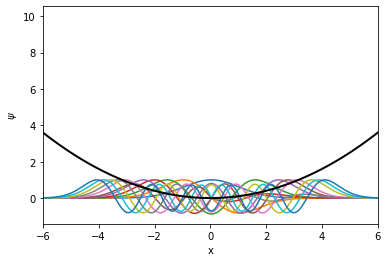

In [32]:
a = 1.0e-11
E1 =  100 # start Energy search at the well depth
dE = 1
npoints = 1000


E_SM = []

fig = plt.figure()
ax = fig.add_subplot(111)

# Bound states must have E < 0 for the square well. 
# Cut off after we have found a few states
while (E1 < 3000-dE):

    if match(E1)*match(E1 + dE) < 0 :  # bracket E
        # find the energy
        E = rtf.bisect(match, E1, E1+dE, 1e-12)
        print('Energy', str(len(E_SM)), '= %.5feV'%(E))
        E_SM.append(E)
        
        dx = 16*a/npoints
        
        # for plotting, must ensure overlap of left and right solutions 
        p_up = QM(E, npoints = npoints+4, x_start = -10, x_end = 0+4*dx)
        p_down = QM(E, npoints = npoints-4, x_start = 10, x_end = 0+4*dx)
        
        p_up.scipy_trajectory()
        p_down.scipy_trajectory()
        
        # scale factor
        scale = p_up.uv_end[0]/p_down.uv_end[0]
        
        # full solution, combine up and down solutions
        psi_x = np.concatenate((p_up.uv[:-1,0], scale*p_down.uv[::-1,0]))
        xa = np.linspace(-10,10, 2*npoints-1, endpoint = True)
        
        # plot the scaled solution (not normalized), scale maximum to 1 for plotting purposes
        ax.plot(xa, psi_x/max(psi_x))
    #else : 
    #    print("No bracket, increasing energy to", E1+dE)
    E1 += dE

# plot the potential
ax.plot(xa, np.vectorize(p_up.Potential)(xa)/10., color = 'k', lw =2)
ax.set_xlim([-6, 6])
ax.set_xlabel('x')
ax.set_ylabel('$\psi$')
plt.show()

In [42]:
print('Equally spaced energy states')
for i in range(len(E_SM)-1):
    print('states {} and {}='.format(i,i+1), round(E_SM[i+1]-E_SM[i],7), 'eV')

Equally spaced energy states
states 0 and 1= 276.1692364 eV
states 1 and 2= 276.1692344 eV
states 2 and 3= 276.1692378 eV
states 3 and 4= 276.1692358 eV
states 4 and 5= 276.1692404 eV
states 5 and 6= 276.1692374 eV
states 6 and 7= 276.1692382 eV
states 7 and 8= 276.1692391 eV
states 8 and 9= 276.1692293 eV
states 9 and 10= 276.1692412 eV


(b) Now modify your program to calculate the same ten energies for the anharmonic oscillator with $V(x) = V_0x^2/a^2 + V_0'x^4/a^4$, with $V_0' = 0.1V_0$ and the same parameter values as in part a. Plot level number vs. energy for the haromonic and anharmonic oscillator on the same graph (you may choose units of energy where $\hbar = m = 1$. What do you notice about how the energy varies with level number for each case?

In [55]:
class QM(object):
    def __init__(self,E, npoints, x_start, x_end = 0, u0 = 0.0, v0 = 0.01):
        self.E = E
        self.npoints = npoints
        self.uv0 = np.array([u0, v0]) # NumPy array with initial position and velocity
       
        # always want to start at furthest point and go to zero
        self.xarray = np.linspace(x_start, x_end, npoints, endpoint = True) # include final timepoint

    def scipy_trajectory(self):
        """calculate trajectory using SciPy ode integrator"""
        self.uv = odeint(self.sch, self.uv0, self.xarray)
        self.uv_end = self.uv[-1]


    def sch(self, uv, x):
        unit_correction = 6.242e18

        """right hand side of the differential equation"""
        u = uv[1]
        v = 2*(self.Potential(x) - self.E)*uv[0]
        return np.ravel(np.array([u, v]))

    def Potential(self, x):
        V0 = 50
        a = 1e-11
        return (V0/a**2)*x**2 + (0.1*V0/a**4)*x**4

In [56]:
# the matching function
def match(En):
    #a = 1.0e-11
    p_up = QM(E = En, npoints = 1000, x_start = -10)
    p_down = QM(E = En, npoints = 1000, x_start = 10)
    p_up.scipy_trajectory()
    p_down.scipy_trajectory()

    return p_down.uv_end[0]*p_up.uv_end[1] - p_down.uv_end[1]*p_up.uv_end[0]

KeyboardInterrupt: 

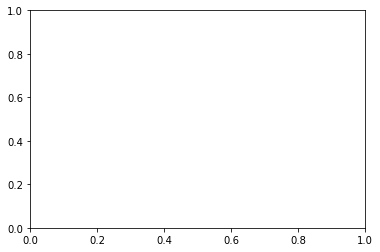

In [62]:
a = 1.0e-3
E1 =  100 # start Energy search at the well depth
dE = 0.01
npoints = 1000


E_SM = []

fig = plt.figure()
ax = fig.add_subplot(111)

# Bound states must have E < 0 for the square well. 
# Cut off after we have found a few states
while (E1 < 1000-dE):

    if match(E1)*match(E1 + dE) < 0 :  # bracket E
        # find the energy
        E = rtf.bisect(match, E1, E1+dE, 1e-12)
        print('Energy', str(len(E_SM)), '= %.5feV'%(E))
        E_SM.append(E)
        
        dx = 16*a/npoints
        
        # for plotting, must ensure overlap of left and right solutions 
        p_up = QM(E, npoints = npoints+4, x_start = -10, x_end = 0+4*dx)
        p_down = QM(E, npoints = npoints-4, x_start = 10, x_end = 0+4*dx)
        
        p_up.scipy_trajectory()
        p_down.scipy_trajectory()
        
        # scale factor
        scale = p_up.uv_end[0]/p_down.uv_end[0]
        
        # full solution, combine up and down solutions
        psi_x = np.concatenate((p_up.uv[:-1,0], scale*p_down.uv[::-1,0]))
        xa = np.linspace(-10,10, 2*npoints-1, endpoint = True)
        
        # plot the scaled solution (not normalized), scale maximum to 1 for plotting purposes
        ax.plot(xa, psi_x/max(psi_x))
    #else : 
    #    print("No bracket, increasing energy to", E1+dE)
    E1 += dE

# plot the potential
ax.plot(xa, np.vectorize(p_up.Potential)(xa)/10., color = 'k', lw =2)
ax.set_xlim([-6, 6])
ax.set_xlabel('x')
ax.set_ylabel('$\psi$')
plt.show()